How does the number of fradulent values change on a per-day basis?

In [2]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc, warnings
gc.collect()

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [4]:
START_DATE     = '2017-12-01'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['thour']  = traintr.tdt.dt.hour
traintr['tdate']  = traintr.tdt.dt.date

testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['thour']  = testtr.tdt.dt.hour
testtr['tdate']  = testtr.tdt.dt.date

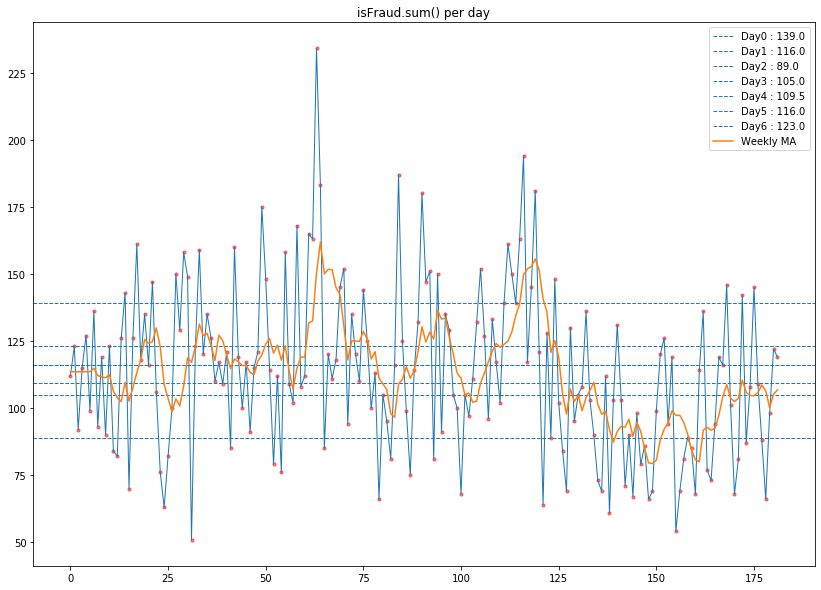

In [6]:
z = traintr.groupby('tdate').isFraud.sum()
plt.figure(figsize=(14,10))
plt.title('isFraud.sum() per day')
plt.plot(z.values, linewidth=1)
plt.scatter(np.arange(z.shape[0]),z.values, s=10, alpha=0.5, c='red')

tags = []
for i in range(7):
    mean = z[i:][::7].median()
    tags.append(plt.axhline(mean, linewidth=1, linestyle='--', label='Day{} : {}'.format(i, np.round(mean,2))))
    
tags.append(plt.plot(z.rolling(7).mean().fillna(z.mean()).values, label='Weekly MA')[0])
plt.legend(handles=tags)
plt.show()

Above we notice that the number of frauds per day seems to stay pretty stable throughout the trainset:

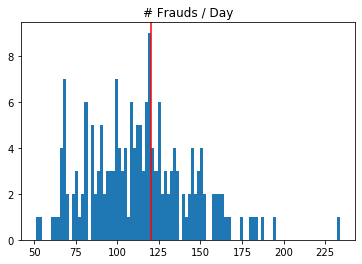

In [17]:
plt.title('# Frauds / Day')
plt.hist(z, 100)
plt.axvline(120, c='r')
plt.show()

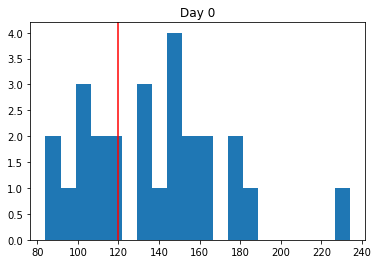

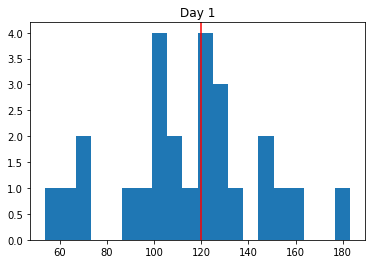

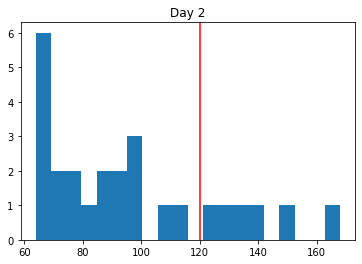

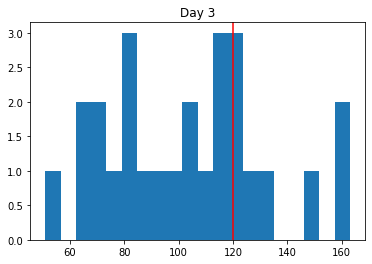

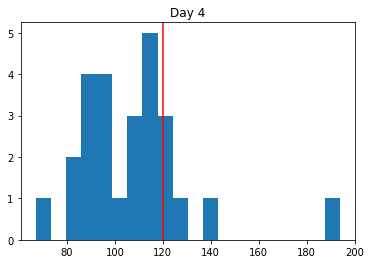

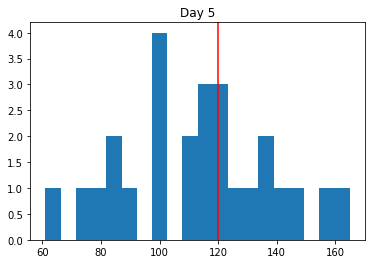

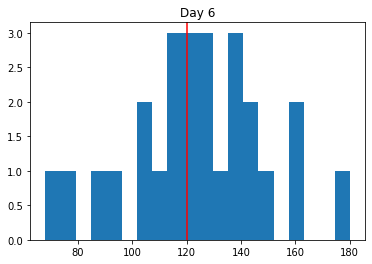

In [18]:
for i in range(7):
    plt.title('Day '+str(i))
    plt.hist(z[i:][::7], 20)
    plt.axvline(120, c='r')
    plt.show()

# Correlation to daily isFraud.sum()?

I wonder if there are any features that have a high correlation with the daily isFraud.sum() = fraudCnt value? Here, I examine some raw features. Of course we cannot calculate fraudCnt for test set though.

In [19]:
traintr['fraudCnt'] = traintr.groupby('tdate').isFraud.transform('sum')

In [20]:
# Here are some columns that had >0.03 correlation
# It looks like I copied and pasted some of them twice.
fraudCnt = traintr[[
    # NOTE: If we lavel encode the M columns, they also
    # have decent corr ...
    'fraudCnt',
    'D4','D6','D10','D11','D14','D15',
    'V38','V25','V45','V37','V44',
    'V67','V86','V66','V99','V95','V96','V97',
    'V147', 'V149', 'V99', 'V100', 'V144', 'V136', 'V139', 'V140', 'V126',
    'V132', 'V101', 'V104', 'V133', 'V127', 'V102', 'V134', 'V128', 'V103',
    'V105', 'V106', 'V143', 'V169', 'V157', 'V185', 'V156', 'V149', 'V158', 'V186', 'V189', 'V188',
    'V190', 'V199', 'V170', 'V176', 'V175', 'V180', 'V177', 'V167', 'V181',
    'V178', 'V182', 'V168', 'V179', 'V183', 'V165', 'V164', 'V229', 'V217', 'V231', 'V243', 'V232', 'V233', 'V226', 'V218', 'V219',
    'V216', 'V210', 'V236', 'V237', 'V221', 'V215', 'V222', 'V234', 'V199',
    'V200', 'V201', 'V230', 'V209', 'V242', 'V244', 'V203', 'V228', 'V246',
    'V202', 'V211', 'V212', 'V204', 'V213', 'V274', 'V275', 'V273', 'V259', 'V297', 'V294', 'V293', 'V279', 'V295',
    'V280', 'V296', 'V298', 'V299', 'V258', 'V257', 'V320', 'V306', 'V317', 'V316', 'V307', 'V325', 'V308', 'V318', 'V336',
    'V299', 'V339', 'V335', 'V338', 'V326', 'V331', 'V322', 'V327', 'V332',
    'V333', 'V323', 'V328', 'V324', 'V329', 'V330'
]].corr().fraudCnt.abs().sort_values()
fraudCnt

TransactionAmt    0.024196
V67               0.030354
V86               0.030636
V169              0.031214
D4                0.031722
V38               0.032431
V157              0.032438
D10               0.033387
V147              0.033796
V274              0.034218
V229              0.034803
V320              0.034817
V217              0.035442
V185              0.035535
V156              0.035678
V25               0.035690
V231              0.035997
V149              0.036231
V149              0.036231
D15               0.036445
V66               0.036747
V243              0.036997
V99               0.037448
V99               0.037448
V45               0.037532
V232              0.037819
V100              0.037837
V144              0.037856
V275              0.037945
V233              0.038060
                    ...   
V180              0.095345
V177              0.095593
V211              0.096065
V167              0.096175
V257              0.096307
V181              0.096507
V

It is no surprise to me that variables with high nan ratio (sparse values) have good correlation with isFraud.sum(). We should look for those variables that have a low nan count but high correlation and research them further...

In [32]:
introspect = pd.DataFrame({
    'col': fraudCnt.index,
    'correlation': fraudCnt.values,
    'nas': traintr[fraudCnt.index].isna().sum().values/traintr.shape[0]
})
introspect

,col,correlation,nas
0,TransactionAmt,0.024196,0.000000
1,V67,0.030354,0.130552
2,V86,0.030636,0.150987
3,V169,0.031214,0.763235
4,D4,0.031722,0.286047
5,V38,0.032431,0.286126
6,V157,0.032438,0.861237
7,D10,0.033387,0.128733
8,V147,0.033796,0.861237
9,V274,0.034218,0.779134


In [36]:
introspect[introspect.nas>0.286047].sort_values(['nas','correlation'])

,col,correlation,nas
5,V38,0.032431,0.286126
24,V45,0.037532,0.286126
33,V37,0.039055,0.286126
37,V44,0.040731,0.286126
41,D11,0.042407,0.472935
40,V259,0.042083,0.760531
52,V221,0.047765,0.760531
67,V222,0.052130,0.760531
75,V234,0.054297,0.760531
3,V169,0.031214,0.763235


In [ ]:
# These are the columns with the smallest %nans yet the highest correlation
# to daily fraud count:

V299, V106, V296, D10, V25, V66, D15, V86, D4, V44, D11